# **Environment Setup and Imports**

In [ ]:
import torch
import re
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
import numpy as np, pickle
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import Concatenate, BatchNormalization, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.models import Sequential, Model, load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Clone repository and set working directory
!git clone https://github.com/alexander-harmaty/Breast-Cancer-Prognosis-Prediction.git
%cd Breast-Cancer-Prognosis-Prediction

# Now you can load the dataset from the repo root
file_path = './Clinical_and_Other_Features.xlsx'
clinical_df = pd.read_excel(file_path, header=[1,2])

Cloning into 'Breast-Cancer-Prognosis-Prediction'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 44 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 795.10 KiB | 2.42 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/Breast-Cancer-Prognosis-Prediction/Breast-Cancer-Prognosis-Prediction


# **Data Preprocessing**

## *Data Loading and Header Processing*

### utilities

In [ ]:
# Function to merge multi-index headers to single index headers
def merge_headers(col_tuple):
    # Unpack the tuple: first-level and second-level names
    first, second = col_tuple

    # If newline characters exist, remove and replace with space
    if isinstance(first, str):
        first = first.replace('\n', ' ').strip()
    if isinstance(second, str):
        second = second.replace('\n', ' ').strip()

    # If blank second-headers exist, return first-header only
    if not second or 'Unnamed' in second:
        return first
    # Otherwise, return merged header
    else:
        return f"{first} - {second}"

### scripts

In [ ]:
# Load the data
file_path = './Clinical_and_Other_Features.xlsx'
clinical_df = pd.read_excel(file_path, header=[1, 2])

# Preprocess the column headers
# Merge multi-index headers for all columns
new_columns = [merge_headers(col) for col in clinical_df.columns]
clinical_df.columns = new_columns

# Print column info
print(f"Total columns: {len(clinical_df.columns)}")
print(f"Sample size: {len(clinical_df)}")

Total columns: 98
Sample size: 922


## *Data Encoding*


### utilities

In [ ]:
def encode_clinical_data(df):
    """
    Encodes clinical data with the understanding that real data starts at row 4.
    Rows 1-3 contain header/metadata information.

    Parameters:
    -----------
    df : pandas.DataFrame
        The clinical dataframe to encode

    Returns:
    --------
    pandas.DataFrame
        The encoded dataframe with all columns properly processed
    """
    # Create a copy to avoid modifying the original
    encoded_df = df.copy()

    # pull off patientIDs
    patient_ids = encoded_df['Patient ID'].copy().reset_index(drop=True)
    encoded_df = encoded_df.drop(columns=['Patient ID'])

    # First, check if we need to handle the header rows
    # If the dataframe has already been loaded with headers processed
    # (i.e., headers are in column names), we don't need this step
    if encoded_df.shape[0] >= 4:
        print("Checking if data starts at row 4...")
        # Sample some values to see if first 3 rows appear to be headers
        sample_col = encoded_df.columns[0]
        first_rows = encoded_df.loc[0:3, sample_col].tolist()
        print(f"First rows of sample column: {first_rows}")

        # If first rows look like headers, remove them
        if any(isinstance(val, str) and '=' in str(val) for val in first_rows):
            print("First rows appear to contain metadata. Removing rows 0-3...")
            encoded_df = encoded_df.iloc[3:].reset_index(drop=True)
            print(f"Dataframe shape after removing header rows: {encoded_df.shape}")

    # Identify the target column
    target_col = None
    for col in encoded_df.columns:
        if "Recurrence event" in col:
            target_col = col
            target_values = encoded_df[target_col].copy()
            print(f"Identified target column: {target_col}")
            break

    # Process each column individually
    all_columns = encoded_df.columns.tolist()
    print(f"Processing {len(all_columns)} total columns")

    for col in all_columns:
        # Skip target column for now
        if col == target_col:
            continue

        print(f"Processing column: {col}")

        try:
            # Check column data type
            if encoded_df[col].dtype == 'object':
                # Categorical column
                print(f"  Processing as categorical")

                # Fill missing values
                encoded_df[col] = encoded_df[col].fillna("MISSING")

                # Convert to string
                encoded_df[col] = encoded_df[col].astype(str)

                # Apply label encoding
                le = LabelEncoder()
                encoded_df[col] = le.fit_transform(encoded_df[col])
                print(f"  Encoded {len(le.classes_)} unique values")

            else:
                # Numeric column
                print(f"  Processing as numeric")

                # Handle missing values
                if encoded_df[col].isna().any():
                    if encoded_df[col].isna().all():
                        encoded_df[col] = 0
                        print(f"  All values missing, filled with 0")
                    else:
                        median = encoded_df[col].median()
                        encoded_df[col] = encoded_df[col].fillna(median)
                        print(f"  Filled missing values with median: {median}")

                # Standardize if there's variance
                if encoded_df[col].std() > 0:
                    mean_val = encoded_df[col].mean()
                    std_val = encoded_df[col].std()
                    encoded_df[col] = (encoded_df[col] - mean_val) / std_val
                    print(f"  Standardized numeric column")

        except Exception as e:
            print(f"Error processing column {col}: {str(e)}")

            # Try alternative approach
            try:
                print(f"  Trying alternative encoding approach")

                # Force to string and encode
                encoded_df[col] = encoded_df[col].fillna("MISSING")
                encoded_df[col] = encoded_df[col].astype(str)
                le = LabelEncoder()
                encoded_df[col] = le.fit_transform(encoded_df[col])
                print(f"  Alternative encoding successful")

            except Exception as e2:
                print(f"  Alternative approach failed: {str(e2)}")
                print(f"  Setting column to 0")
                encoded_df[col] = 0

    # Restore target column
    if target_col and 'target_values' in locals():
        encoded_df[target_col] = target_values
        print(f"Restored target column: {target_col}")

    # Final check for any NaN values
    if encoded_df.isna().any().any():
        nan_cols = encoded_df.columns[encoded_df.isna().any()].tolist()
        print(f"Filling NaN values in {len(nan_cols)} columns")
        encoded_df = encoded_df.fillna(0)

    # reattach patientIDs
    encoded_df['Patient ID'] = patient_ids

    print(f"Final encoded dataframe shape: {encoded_df.shape}")
    return encoded_df

### scripts

In [ ]:
# target variable
target_col = "Recurrence event(s) - {0 = no, 1 = yes}"
if target_col not in clinical_df.columns:
    # Find the correct column name by looking for a substring match
    matching_cols = [col for col in clinical_df.columns if "Recurrence event" in col]
    if matching_cols:
        target_col = matching_cols[0]
        print(f"Found target column: {target_col}")
    else:
        raise ValueError("Target column not found! Please check the column names.")

# Encode the data
encoded_df = encode_clinical_data(clinical_df)
print(f"Encoded data shape: {encoded_df.shape}")


Checking if data starts at row 4...
First rows of sample column: [6, 12, 10, 18]
Identified target column: Recurrence event(s) - {0 = no, 1 = yes}
Processing 97 total columns
Processing column: Days to MRI (From the Date of Diagnosis)
  Processing as numeric
  Standardized numeric column
Processing column: Manufacturer - GE MEDICAL SYSTEMS=0, MPTronic software=1, SIEMENS=2
  Processing as numeric
  Standardized numeric column
Processing column: Manufacturer Model Name - Avanto=0, Optima MR450w=1, SIGNA EXCITE=2, SIGNA HDx=3, Signa HDxt=4, Skyra=5, Trio=6, TrioTim=7
  Processing as numeric
  Standardized numeric column
Processing column: Scan Options - FAST_GEMS\SAT_GEMS\ACC_GEMS\PFP\FS=0,FAST_GEMS\SAT_GEMS\MP_GEMS\ACC_GEMS\PFP\FS=1,FAST_GEMS\SAT_GEMS\MP_GEMS\PFP\FS=2,FAST_GEMS\SAT_GEMS\PFP\FS=3,FS=4,PFP\FS=5,PFP\SFS=6,SAT_GEMS\PFP\FS=7,SFS=8
  Processing as numeric
  Standardized numeric column
Processing column: Field Strength (Tesla) - 1.494=0,1.5=1,2.8936=2,3=3
  Processing as numer

## *Data Spliitting and Reshaping*

### utilities

### scripts

In [ ]:
# Split the data into features and target
X = encoded_df.drop(columns=[target_col, 'Patient ID'])
y = encoded_df[target_col]
# X = encoded_df.drop(columns=[target_col]) if target_col in encoded_df.columns else encoded_df
# y = encoded_df[target_col] if target_col in encoded_df.columns else None


# Print info about target distribution
if y is not None:
    print(f"Target distribution:\n{y.value_counts()}")
else:
    print("Warning: Target column not found in encoded dataframe!")

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

# Reshape data for RNN (sequence data)
# RNNs expect input of shape (batch_size, time_steps, features)
X_train_seq = np.expand_dims(X_train.values.astype('float32'), axis=1)
X_val_seq   = np.expand_dims(X_val.values.astype('float32'),   axis=1)
X_test_seq  = np.expand_dims(X_test.values.astype('float32'),  axis=1)
# X_train_seq = np.expand_dims(X_train.values, axis=1)  # shape: (samples, 1, features)
# X_val_seq = np.expand_dims(X_val.values, axis=1)
# X_test_seq = np.expand_dims(X_test.values, axis=1)


# Check for NaN values using np.isnan for NumPy arrays
if np.isnan(X_test_seq).any():
    print("Warning: NaN values found in test data! Filling with 0...")
    X_test_seq = np.nan_to_num(X_test_seq, nan=0.0)

X_train_seq = np.nan_to_num(X_train_seq, nan=0.0)
X_val_seq = np.nan_to_num(X_val_seq, nan=0.0)

print("Sequence shapes:")
print("X_train_seq:", X_train_seq.shape)
print("X_val_seq:", X_val_seq.shape)
print("X_test_seq:", X_test_seq.shape)

Target distribution:
Recurrence event(s) - {0 = no, 1 = yes}
0.0    835
1.0     87
Name: count, dtype: int64
Training set size: (645, 96) (645,)
Validation set size: (138, 96) (138,)
Test set size: (139, 96) (139,)
Sequence shapes:
X_train_seq: (645, 1, 96)
X_val_seq: (138, 1, 96)
X_test_seq: (139, 1, 96)


# **RNN Model**

## *Model Building*

### utilities

In [ ]:
def build_advanced_rnn_model(input_shape, rnn_type='LSTM', units=64,
                            bidirectional=True, attention=False,
                            dropout_rate=0.3, l1_reg=0.0001, l2_reg=0.0001):
    """
    Build an advanced RNN model with various architectural improvements:
    - Bidirectional RNN layers
    - Batch normalization
    - Regularization (dropout, L1, L2)

    Parameters:
    -----------
    input_shape : tuple
        Shape of input data (time_steps, features)
    rnn_type : str, default='LSTM'
        Type of RNN layer ('LSTM' or 'GRU')
    units : int, default=64
        Number of RNN units
    bidirectional : bool, default=True
        Whether to use bidirectional RNNs
    attention : bool, default=False
        Whether to add an attention mechanism (simplified)
    dropout_rate : float, default=0.3
        Dropout rate for regularization
    l1_reg : float, default=0.0001
        L1 regularization strength
    l2_reg : float, default=0.0001
        L2 regularization strength

    Returns:
    --------
    keras.Model
        Compiled RNN model
    """
    # Simple version for simpler architectural choices
    if not bidirectional:
        model = Sequential()

        # Use specified RNN type
        if rnn_type == 'LSTM':
            model.add(LSTM(units, input_shape=input_shape,
                          kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                          recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                          return_sequences=False))
        elif rnn_type == 'GRU':
            model.add(GRU(units, input_shape=input_shape,
                         kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                         recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                         return_sequences=False))
        else:
            raise ValueError(f"Unknown RNN type: {rnn_type}")

        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))

    # More complex model with bidirectional RNNs
    else:
        # Create functional API model for more flexibility
        inputs = Input(shape=input_shape)

        # Configure RNN layer based on parameters
        if rnn_type == 'LSTM':
            rnn_layer = LSTM(units,
                            kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                            recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                            return_sequences=False)  # No need for sequences in this implementation
        elif rnn_type == 'GRU':
            rnn_layer = GRU(units,
                           kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                           recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
                           return_sequences=False)  # No need for sequences in this implementation
        else:
            raise ValueError(f"Unknown RNN type: {rnn_type}")

        # Add bidirectional wrapper
        rnn_output = Bidirectional(rnn_layer)(inputs)

        # Add dense layers with regularization
        x = BatchNormalization()(rnn_output)
        x = Dropout(dropout_rate)(x)
        x = Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

### scripts

In [ ]:
# Build the advanced RNN model
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # (time_steps, features)
advanced_model = build_advanced_rnn_model(
    input_shape=input_shape,
    rnn_type='LSTM',       # 'LSTM' or 'GRU'
    units=128,             # Number of RNN units
    bidirectional=True,    # Use bidirectional RNN
    attention=False,       # Attention mechanism not needed for this data
    dropout_rate=0.3,      # Dropout rate for regularization
    l1_reg=0.0001,         # L1 regularization strength
    l2_reg=0.0001          # L2 regularization strength
)

## *Model Training*


### utilities

In [ ]:
def train_with_advanced_callbacks(model, X_train, y_train, X_val, y_val,
                                 batch_size=32, epochs=100,
                                 early_stopping_patience=10,
                                 reduce_lr_patience=5,
                                 model_checkpoint_path='best_model.h5'):
    """
    Train model with advanced callbacks for better performance

    Parameters:
    -----------
    model : keras.Model
        The compiled model to train
    X_train, y_train : array-like
        Training data and labels
    X_val, y_val : array-like
        Validation data and labels
    batch_size : int, default=32
        Batch size for training
    epochs : int, default=100
        Maximum number of epochs
    early_stopping_patience : int, default=10
        Patience for early stopping
    reduce_lr_patience : int, default=5
        Patience for learning rate reduction
    model_checkpoint_path : str, default='best_model.h5'
        Path to save the best model weights

    Returns:
    --------
    history : dict
        Training history
    """
    # Define callbacks
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            patience=early_stopping_patience,
            restore_best_weights=True,
            verbose=1
        ),
        # Reduce learning rate when validation loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=reduce_lr_patience,
            min_lr=1e-6,
            verbose=1
        ),
        # Save the best model based on validation loss
        ModelCheckpoint(
            filepath=model_checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return history

### scripts

In [ ]:
# Train the model with advanced callbacks
history = train_with_advanced_callbacks(
    model=advanced_model,
    X_train=X_train_seq,
    y_train=y_train,
    X_val=X_val_seq,
    y_val=y_val,
    batch_size=32,
    epochs=100,
    early_stopping_patience=10,
    reduce_lr_patience=5,
    model_checkpoint_path='best_rnn_model.h5'
)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4588 - auc: 0.4402 - loss: 2.0034 - precision: 0.0871 - recall: 0.5333
Epoch 1: val_loss improved from inf to 1.19006, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.4607 - auc: 0.4420 - loss: 1.9951 - precision: 0.0873 - recall: 0.5338 - val_accuracy: 0.8768 - val_auc: 0.6697 - val_loss: 1.1901 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6198 - auc: 0.6696 - loss: 1.3793 - precision: 0.1362 - recall: 0.6600
Epoch 2: val_loss improved from 1.19006 to 0.93373, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6195 - auc: 0.6682 - loss: 1.3776 - precision: 0.1359 - recall: 0.6581 - val_accuracy: 0.8623 - val_auc: 0.6770 - val_loss: 0.9337 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6180 - auc: 0.6620 - loss: 1.1203 - precision: 0.1463 - recall: 0.6966
Epoch 3: val_loss improved from 0.93373 to 0.74959, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6181 - auc: 0.6605 - loss: 1.1191 - precision: 0.1455 - recall: 0.6922 - val_accuracy: 0.8696 - val_auc: 0.7129 - val_loss: 0.7496 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6990 - auc: 0.7204 - loss: 0.8895 - precision: 0.1337 - recall: 0.6334
Epoch 4: val_loss improved from 0.74959 to 0.70050, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6998 - auc: 0.7148 - loss: 0.8877 - precision: 0.1374 - recall: 0.6263 - val_accuracy: 0.8768 - val_auc: 0.6884 - val_loss: 0.7005 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7024 - auc: 0.6096 - loss: 0.8176 - precision: 0.1426 - recall: 0.4782
Epoch 5: val_loss improved from 0.70050 to 0.65680, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7075 - auc: 0.6200 - loss: 0.8120 - precision: 0.1469 - recall: 0.4873 - val_accuracy: 0.8551 - val_auc: 0.6894 - val_loss: 0.6568 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/100
11/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7594 - auc: 0.8389 - loss: 0.7052 - precision: 0.1892 - recall: 0.8277 
Epoch 6: val_loss improved from 0.65680 to 0.61630, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7693 - auc: 0.8096 - loss: 0.7023 - precision: 0.1974 - recall: 0.7468 - val_accuracy: 0.8841 - val_auc: 0.7124 - val_loss: 0.6163 - val_precision: 1.0000 - val_recall: 0.0588 - learning_rate: 0.0010
Epoch 7/100
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7543 - auc: 0.6328 - loss: 0.7362 - precision: 0.1406 - recall: 0.4647 
Epoch 7: val_loss improved from 0.61630 to 0.53850, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7606 - auc: 0.6482 - loss: 0.7198 - precision: 0.1530 - recall: 0.4598 - val_accuracy: 0.8768 - val_auc: 0.9047 - val_loss: 0.5385 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 8/100
11/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8277 - auc: 0.7825 - loss: 0.6210 - precision: 0.3440 - recall: 0.5463 
Epoch 8: val_loss did not improve from 0.53850
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8216 - auc: 0.7646 - loss: 0.6267 - precision: 0.2949 - recall: 0.5185 - val_accuracy: 0.8623 - val_auc: 0.7953 - val_loss: 0.5469 - val_precision: 0.2500 - val_recall: 0.0588 - learning_rate: 0.0010
Epoch 9/100
13/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8845 - auc: 0.7759 - loss: 0.5772 - precision: 0.4534 - recall: 0.5230 
Epoch 9: val_loss improved from 0.53850 to 0.53283, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8789 - auc: 0.7730 - loss: 0.5784 - precision: 0.4097 - recall: 0.5169 - val_accuracy: 0.8841 - val_auc: 0.8148 - val_loss: 0.5328 - val_precision: 1.0000 - val_recall: 0.0588 - learning_rate: 0.0010
Epoch 10/100
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8855 - auc: 0.7779 - loss: 0.5547 - precision: 0.3660 - recall: 0.5129 
Epoch 10: val_loss improved from 0.53283 to 0.50706, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8840 - auc: 0.7739 - loss: 0.5513 - precision: 0.3648 - recall: 0.4978 - val_accuracy: 0.8841 - val_auc: 0.8678 - val_loss: 0.5071 - val_precision: 1.0000 - val_recall: 0.0588 - learning_rate: 0.0010
Epoch 11/100
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8961 - auc: 0.8724 - loss: 0.5002 - precision: 0.3739 - recall: 0.6335 
Epoch 11: val_loss improved from 0.50706 to 0.48222, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8882 - auc: 0.8299 - loss: 0.5091 - precision: 0.3523 - recall: 0.5427 - val_accuracy: 0.8841 - val_auc: 0.8488 - val_loss: 0.4822 - val_precision: 1.0000 - val_recall: 0.0588 - learning_rate: 0.0010
Epoch 12/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8816 - auc: 0.8414 - loss: 0.4968 - precision: 0.3674 - recall: 0.4654
Epoch 12: val_loss did not improve from 0.48222
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8824 - auc: 0.8434 - loss: 0.4962 - precision: 0.3700 - recall: 0.4738 - val_accuracy: 0.8913 - val_auc: 0.8629 - val_loss: 0.4891 - val_precision: 0.7500 - val_recall: 0.1765 - learning_rate: 0.0010
Epoch 13/100
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9129 - auc: 0.8195 - loss: 0.4713 - precision: 0.5053 - recall: 0.5315
Epoch 13: val_loss did not improve from 0.48222
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9126 - auc: 0.8148 - loss: 0.4714 - precision: 0.5016 - recall: 0.53

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9081 - auc: 0.8588 - loss: 0.4122 - precision: 0.5787 - recall: 0.4229 - val_accuracy: 0.8986 - val_auc: 0.8807 - val_loss: 0.4424 - val_precision: 0.7143 - val_recall: 0.2941 - learning_rate: 5.0000e-04
Epoch 18/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9407 - auc: 0.9176 - loss: 0.3579 - precision: 0.6594 - recall: 0.6152
Epoch 18: val_loss did not improve from 0.44236
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9402 - auc: 0.9161 - loss: 0.3587 - precision: 0.6567 - recall: 0.6121 - val_accuracy: 0.9203 - val_auc: 0.8865 - val_loss: 0.4655 - val_precision: 0.6875 - val_recall: 0.6471 - learning_rate: 5.0000e-04
Epoch 19/100
11/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9380 - auc: 0.9491 - loss: 0.3423 - precision: 0.6475 - recall: 0.6938  
Epoch 19: val_loss did not improve from 0.44236
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9442 - auc: 0.9348 - loss: 0.3423 - precision: 0.6866 - recal

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9459 - auc: 0.9017 - loss: 0.3516 - precision: 0.6296 - recall: 0.6703 - val_accuracy: 0.9203 - val_auc: 0.8943 - val_loss: 0.3985 - val_precision: 0.8750 - val_recall: 0.4118 - learning_rate: 5.0000e-04
Epoch 21/100
11/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9666 - auc: 0.9073 - loss: 0.3167 - precision: 0.8594 - recall: 0.7424 
Epoch 21: val_loss improved from 0.39853 to 0.36288, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9628 - auc: 0.9159 - loss: 0.3158 - precision: 0.8241 - recall: 0.7146 - val_accuracy: 0.9203 - val_auc: 0.9110 - val_loss: 0.3629 - val_precision: 0.8000 - val_recall: 0.4706 - learning_rate: 5.0000e-04
Epoch 22/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9447 - auc: 0.9542 - loss: 0.3163 - precision: 0.6716 - recall: 0.5873
Epoch 22: val_loss improved from 0.36288 to 0.33443, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9459 - auc: 0.9536 - loss: 0.3154 - precision: 0.6815 - recall: 0.5984 - val_accuracy: 0.9420 - val_auc: 0.9387 - val_loss: 0.3344 - val_precision: 0.8462 - val_recall: 0.6471 - learning_rate: 5.0000e-04
Epoch 23/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9630 - auc: 0.9396 - loss: 0.2984 - precision: 0.7156 - recall: 0.7516
Epoch 23: val_loss improved from 0.33443 to 0.33003, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9632 - auc: 0.9407 - loss: 0.2980 - precision: 0.7196 - recall: 0.7546 - val_accuracy: 0.9565 - val_auc: 0.9319 - val_loss: 0.3300 - val_precision: 0.8667 - val_recall: 0.7647 - learning_rate: 5.0000e-04
Epoch 24/100
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9347 - auc: 0.9231 - loss: 0.3267 - precision: 0.7865 - recall: 0.6094
Epoch 24: val_loss improved from 0.33003 to 0.31760, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9364 - auc: 0.9242 - loss: 0.3238 - precision: 0.7604 - recall: 0.6178 - val_accuracy: 0.9420 - val_auc: 0.9336 - val_loss: 0.3176 - val_precision: 0.9091 - val_recall: 0.5882 - learning_rate: 5.0000e-04
Epoch 25/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9745 - auc: 0.9686 - loss: 0.2666 - precision: 0.8857 - recall: 0.8285
Epoch 25: val_loss improved from 0.31760 to 0.31669, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9736 - auc: 0.9677 - loss: 0.2684 - precision: 0.8798 - recall: 0.8210 - val_accuracy: 0.9493 - val_auc: 0.9638 - val_loss: 0.3167 - val_precision: 1.0000 - val_recall: 0.5882 - learning_rate: 5.0000e-04
Epoch 26/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9627 - auc: 0.9764 - loss: 0.2621 - precision: 0.8184 - recall: 0.7325
Epoch 26: val_loss did not improve from 0.31669
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9623 - auc: 0.9754 - loss: 0.2632 - precision: 0.8165 - recall: 0.7282 - val_accuracy: 0.6667 - val_auc: 0.8960 - val_loss: 0.7340 - val_precision: 0.2542 - val_recall: 0.8824 - learning_rate: 5.0000e-04
Epoch 27/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9493 - auc: 0.9388 - loss: 0.3204 - precision: 0.7461 - recall: 0.7096
Epoch 27: val_loss did not improve from 0.31669
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9492 - auc: 0.9379 - loss: 0.3204 - precision: 0.7439 - recall

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9573 - auc: 0.9267 - loss: 0.2809 - precision: 0.7478 - recall: 0.6820 - val_accuracy: 0.9565 - val_auc: 0.9560 - val_loss: 0.2767 - val_precision: 0.8667 - val_recall: 0.7647 - learning_rate: 5.0000e-04
Epoch 30/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9613 - auc: 0.9577 - loss: 0.2520 - precision: 0.8476 - recall: 0.6692
Epoch 30: val_loss did not improve from 0.27667
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9609 - auc: 0.9552 - loss: 0.2541 - precision: 0.8460 - recall: 0.6645 - val_accuracy: 0.9638 - val_auc: 0.9473 - val_loss: 0.2824 - val_precision: 0.8750 - val_recall: 0.8235 - learning_rate: 5.0000e-04
Epoch 31/100
11/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9407 - auc: 0.9617 - loss: 0.2961 - precision: 0.8128 - recall: 0.6267  
Epoch 31: val_loss did not improve from 0.27667
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9486 - auc: 0.9625 - loss: 0.2830 - precision: 0.7898 - reca

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9743 - auc: 0.9580 - loss: 0.2375 - precision: 0.9409 - recall: 0.7120 - val_accuracy: 0.9493 - val_auc: 0.9601 - val_loss: 0.2702 - val_precision: 0.7778 - val_recall: 0.8235 - learning_rate: 5.0000e-04
Epoch 33/100
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9521 - auc: 0.9714 - loss: 0.2708 - precision: 0.8804 - recall: 0.6467  
Epoch 33: val_loss did not improve from 0.27022
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9569 - auc: 0.9732 - loss: 0.2669 - precision: 0.8786 - recall: 0.6511 - val_accuracy: 0.9203 - val_auc: 0.9701 - val_loss: 0.2860 - val_precision: 0.8000 - val_recall: 0.4706 - learning_rate: 5.0000e-04
Epoch 34/100
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9538 - auc: 0.9725 - loss: 0.2484 - precision: 0.9229 - recall: 0.6494  
Epoch 34: val_loss improved from 0.27022 to 0.25901, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9538 - auc: 0.9623 - loss: 0.2528 - precision: 0.8738 - recall: 0.6493 - val_accuracy: 0.9565 - val_auc: 0.9475 - val_loss: 0.2590 - val_precision: 0.8235 - val_recall: 0.8235 - learning_rate: 5.0000e-04
Epoch 35/100
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9567 - auc: 0.9410 - loss: 0.2669 - precision: 0.7990 - recall: 0.6574
Epoch 35: val_loss improved from 0.25901 to 0.24524, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9585 - auc: 0.9404 - loss: 0.2649 - precision: 0.8147 - recall: 0.6665 - val_accuracy: 0.9565 - val_auc: 0.9730 - val_loss: 0.2452 - val_precision: 0.9231 - val_recall: 0.7059 - learning_rate: 5.0000e-04
Epoch 36/100
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9572 - auc: 0.8935 - loss: 0.2740 - precision: 0.8932 - recall: 0.6004 
Epoch 36: val_loss improved from 0.24524 to 0.23859, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9619 - auc: 0.9098 - loss: 0.2637 - precision: 0.8940 - recall: 0.6457 - val_accuracy: 0.9493 - val_auc: 0.9703 - val_loss: 0.2386 - val_precision: 0.8571 - val_recall: 0.7059 - learning_rate: 5.0000e-04
Epoch 37/100
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9635 - auc: 0.9591 - loss: 0.2414 - precision: 0.6776 - recall: 0.8024 
Epoch 37: val_loss did not improve from 0.23859
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9585 - auc: 0.9479 - loss: 0.2497 - precision: 0.7188 - recall: 0.7126 - val_accuracy: 0.9638 - val_auc: 0.9606 - val_loss: 0.2472 - val_precision: 0.8750 - val_recall: 0.8235 - learning_rate: 5.0000e-04
Epoch 38/100
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9549 - auc: 0.9761 - loss: 0.2413 - precision: 0.8157 - recall: 0.7752 
Epoch 38: val_loss improved from 0.23859 to 0.23236, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9651 - auc: 0.9764 - loss: 0.2325 - precision: 0.8542 - recall: 0.7934 - val_accuracy: 0.9710 - val_auc: 0.9696 - val_loss: 0.2324 - val_precision: 1.0000 - val_recall: 0.7647 - learning_rate: 5.0000e-04
Epoch 39/100
11/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9803 - auc: 0.9706 - loss: 0.2188 - precision: 0.9926 - recall: 0.7686  
Epoch 39: val_loss did not improve from 0.23236
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9762 - auc: 0.9687 - loss: 0.2243 - precision: 0.9286 - recall: 0.7766 - val_accuracy: 0.9783 - val_auc: 0.9604 - val_loss: 0.2838 - val_precision: 0.9375 - val_recall: 0.8824 - learning_rate: 5.0000e-04
Epoch 40/100
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9709 - auc: 0.9632 - loss: 0.2270 - precision: 0.8223 - recall: 0.7888 
Epoch 40: val_loss did not improve from 0.23236
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9664 - auc: 0.9525 - loss: 0.2370 - precision: 0.8006 - reca

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9700 - auc: 0.9872 - loss: 0.2035 - precision: 0.8889 - recall: 0.7479 - val_accuracy: 0.9638 - val_auc: 0.9767 - val_loss: 0.2076 - val_precision: 0.9286 - val_recall: 0.7647 - learning_rate: 2.5000e-04
Epoch 45/100
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9601 - auc: 0.9576 - loss: 0.2322 - precision: 0.8311 - recall: 0.7249 
Epoch 45: val_loss did not improve from 0.20763
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9582 - auc: 0.9556 - loss: 0.2354 - precision: 0.8188 - recall: 0.7089 - val_accuracy: 0.9710 - val_auc: 0.9713 - val_loss: 0.2139 - val_precision: 1.0000 - val_recall: 0.7647 - learning_rate: 2.5000e-04
Epoch 46/100
11/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9773 - auc: 0.9857 - loss: 0.1957 - precision: 0.9113 - recall: 0.7914  
Epoch 46: val_loss did not improve from 0.20763
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9710 - auc: 0.9627 - loss: 0.2114 - precision: 0.8818 - rec

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9657 - auc: 0.9778 - loss: 0.2224 - precision: 0.8694 - recall: 0.7532 - val_accuracy: 0.9710 - val_auc: 0.9718 - val_loss: 0.1996 - val_precision: 0.9333 - val_recall: 0.8235 - learning_rate: 2.5000e-04
Epoch 48/100
13/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9813 - auc: 0.9902 - loss: 0.1875 - precision: 0.8637 - recall: 0.8588  
Epoch 48: val_loss improved from 0.19958 to 0.19305, saving model to best_rnn_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9783 - auc: 0.9836 - loss: 0.1929 - precision: 0.8706 - recall: 0.8328 - val_accuracy: 0.9783 - val_auc: 0.9711 - val_loss: 0.1930 - val_precision: 1.0000 - val_recall: 0.8235 - learning_rate: 2.5000e-04
Epoch 49/100
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9745 - auc: 0.9941 - loss: 0.1880 - precision: 0.7673 - recall: 0.9194 
Epoch 49: val_loss did not improve from 0.19305
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9723 - auc: 0.9840 - loss: 0.1955 - precision: 0.7912 - recall: 0.8676 - val_accuracy: 0.9710 - val_auc: 0.9762 - val_loss: 0.2023 - val_precision: 1.0000 - val_recall: 0.7647 - learning_rate: 2.5000e-04
Epoch 50/100
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9707 - auc: 0.9575 - loss: 0.2348 - precision: 0.9370 - recall: 0.7696 
Epoch 50: val_loss did not improve from 0.19305
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9728 - auc: 0.9622 - loss: 0.2251 - precision: 0.9368 - recal

## *Model Evaluation*

### utilities

In [ ]:
def evaluate_binary_classifier(model, X_test, y_test, class_names=['No Recurrence', 'Recurrence']):
    """
    Comprehensive evaluation of binary classifier with various metrics and plots

    Parameters:
    -----------
    model : keras.Model
        Trained model to evaluate
    X_test, y_test : array-like
        Test data and labels
    class_names : list, default=['No Recurrence', 'Recurrence']
        Names of the classes for plotting

    Returns:
    --------
    dict
        Dictionary of evaluation metrics
    """
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.savefig('confusion_matrix_advanced.png')
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve_advanced.png')
    plt.show()

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig('pr_curve_advanced.png')
    plt.show()

    # Return all metrics in a dictionary
    metrics = {
        'accuracy': test_accuracy,
        'auc': test_auc,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': report['weighted avg']['f1-score'],
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

    return metrics

### scripts

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
               precision    recall  f1-score   support

No Recurrence       0.99      1.00      1.00       124
   Recurrence       1.00      0.93      0.97        15

     accuracy                           0.99       139
    macro avg       1.00      0.97      0.98       139
 weighted avg       0.99      0.99      0.99       139



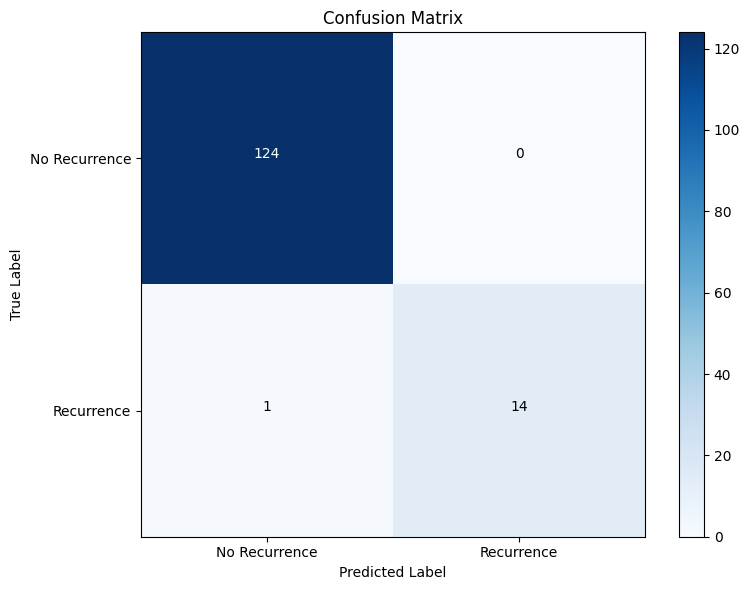

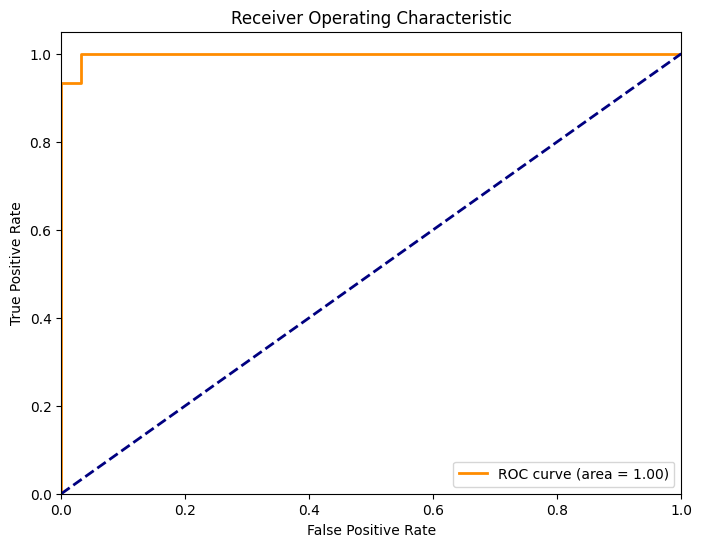

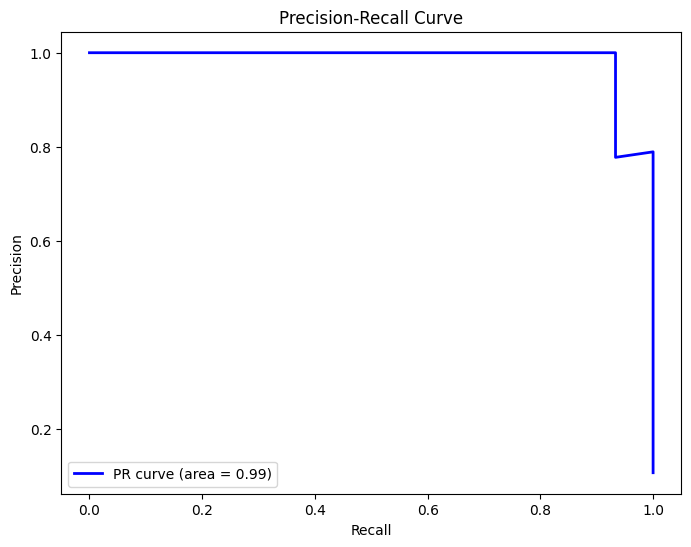

Final model performance:
Accuracy: 0.9928
AUC: 0.9976
F1 Score: 0.9927


In [ ]:
# Evaluate the model
metrics = evaluate_binary_classifier(
    model=advanced_model,
    X_test=X_test_seq,
    y_test=y_test
)

print(f"Final model performance:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"AUC: {metrics['auc']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")

# Pickle File

In [ ]:
from google.colab import files

# Build pickle file
best_rnn = load_model('best_rnn_model.h5')
penult = best_rnn.layers[-3].output
feat_extractor = Model(inputs=best_rnn.input, outputs=penult)
rnn_feats = feat_extractor.predict(np.vstack((X_train_seq, X_val_seq, X_test_seq)))
all_labels = np.concatenate([y_train, y_val, y_test])
rnn_ids = encoded_df['Patient ID'].tolist()

with open('rnn_features.pkl', 'wb') as f:
    pickle.dump({
      'features': rnn_feats,
      'labels':   all_labels,
      'ids':      rnn_ids,
    }, f)

print("Saved RNN features to rnn_features.pkl")

files.download('rnn_features.pkl')

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Saved RNN features to rnn_features.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>